In [1]:
import sys

from forcefield import CGForceField
from model_builder import CGModelBuilder
from openmm import LangevinMiddleIntegrator, MonteCarloBarostat, unit
from openmm.app import PDBFile, Simulation, StateDataReporter, XTCReporter


In [4]:
builder = CGModelBuilder(
    smiles_sequence="[EO]100",
    bond_length=0.36,  # nm
    min_dist=0.41,  # nm
    max_tries=50000,
)
topology, positions = builder.create_molecule()

with open("peo100.pdb", "w") as f:
    PDBFile.writeFile(topology, positions, f)

structures = [
    {
        "pdb": "peo100.pdb",
        "number": 100,
        "box": (0, 0, 0, 200, 200, 200),
    },
]
topology, positions = builder.create_packed_model(
    structures,
    box_size=(200, 200, 200),  # nm
    output_pdb="peo10_100.pdb",
)

In [5]:
param_dict = {
    "BOND": {
        ("EO", "EO"): {"r0": 0.36, "k": 7000},
    },
    "ANGLE": {
        ("EO", "EO", "EO"): {"theta0": 2.147, "k": 80},
    },
    "TORSION": {
        ("EO", "EO", "EO", "EO"): [
            {"periodicity": 1, "phase": 0.0, "k": 0.657},
            {"periodicity": 2, "phase": 0.0, "k": 0.657},
        ]
    },
    "NONBONDED": {
        "EO": {"sigma": 0.41, "epsilon": 2.35, "charge": 0.0, "mass": 44.0},
    },
}
ff = CGForceField.from_dict(param_dict)
system = ff.create_system(topology)

In [ ]:
!rm md_traj.xtc md.log
temperature = 300 * unit.kelvin
friction = 10 / unit.picosecond
timestep = 40 * unit.femtosecond
integrator = LangevinMiddleIntegrator(temperature, friction, timestep)
simulation = Simulation(topology, system, integrator)

barostat = MonteCarloBarostat(1.0 * unit.atmospheres, temperature)
simulation.system.addForce(barostat)

simulation.context.setPositions(positions)

simulation.reporters.append(XTCReporter("md_traj.xtc", 1000))
simulation.reporters.append(
    StateDataReporter(
        sys.stdout,
        1000,
        step=True,
        time=True,
        potentialEnergy=True,
        kineticEnergy=True,
        temperature=True,
        volume=True,
        density=True,
    )
)
simulation.reporters.append(
    StateDataReporter(
        "md.log",
        1000,
        step=True,
        time=True,
        potentialEnergy=True,
        kineticEnergy=True,
        temperature=True,
        volume=True,
        density=True,
    )
)

state = simulation.context.getState(
    getPositions=True, getEnergy=True, enforcePeriodicBox=True
)
PDBFile.writeFile(
    simulation.topology, state.getPositions(), open("md_traj_init.pdb", "w")
)
simulation.context.reinitialize(preserveState=True)
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
simulation.step(100_000)

#"Step","Time (ps)","Potential Energy (kJ/mole)","Kinetic Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Density (g/mL)"
1000,39.999999999999325,-35116.000100378325,37699.794081977605,302.28286792435154,6981176.765188586,0.00010465817069692196
2000,80.00000000000131,-36746.47882407601,37047.58494568599,297.0533526708732,6045708.598271029,0.00012085220080991704


In [5]:
import MDAnalysis as mda
import nglview as nv

bonds = list(topology.bonds())
bonds_nglview = []
for bond in bonds:
    bonds_nglview.append((bond[0].index, bond[1].index))
u = mda.Universe("md_traj_init.pdb", "md_traj.xtc")
u.add_TopologyAttr("bonds", bonds_nglview)
view = nv.show_mdanalysis(u)
view.add_ball_and_stick()
view.add_representation("ball+stick", colorScheme="resname")
view.add_representation("unitcell")
view

/home/mori/work/flowapp/.venv/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(max_frame=99)

In [ ]:
import pandas as pd

df = pd.read_csv("md.log")

: 

: 

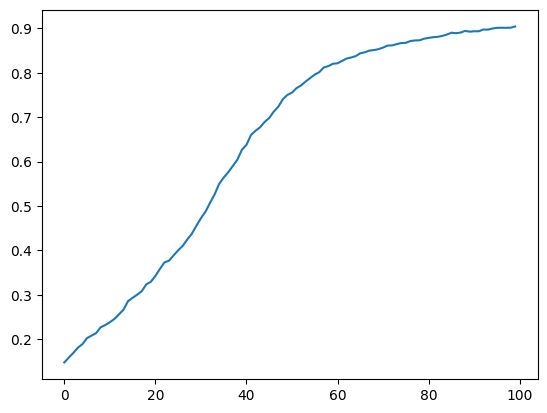

: 

: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df["Density (g/mL)"])

: 

: 